In [1]:
import os
import glob
%matplotlib inline

def load(basedir):
    image_types = os.listdir(basedir)
    files = []

    for imtype in image_types:
        files.extend(glob.glob(basedir+imtype+'/*'))

    return files

def save_file_list(flist, fname):
    with open(fname, "w") as f:
        for fn in flist:
            f.write(fn+"\n")
            
cars =  load("data/vehicles/")
#save_file_list(cars, "cars.txt")
print("Vehicle samples " , len(cars))

notcars = load("data/non-vehicles/")
print("Non Vehicle samples " , len(notcars))
save_file_list(notcars, "notcars.txt")


Vehicle samples  8792
Non Vehicle samples  8968


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()     
    color2 = cv2.resize(img[:,:,1], size).ravel()     
    color3 = cv2.resize(img[:,:,2], size).ravel()     
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):#, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins) #, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins) #, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins) #, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features    

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [5]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [47]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6,color2=(0,0,255)):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    colors = [color,color2]
    
    for idx, bbox in enumerate(bboxes):
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], colors[idx%2], thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:       
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)                
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


In [8]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows        

In [9]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])            

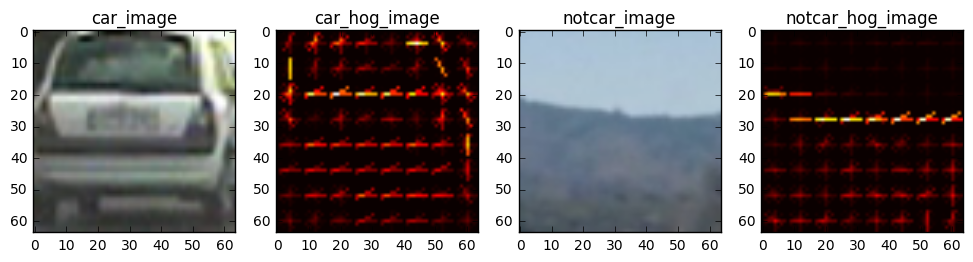

In [10]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space='RGB'
orient=6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image,
                                                  color_space=color_space,                             
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins,                         
                                                  orient=orient, 
                                                  pix_per_cell=pix_per_cell,                             
                                                  cell_per_block=cell_per_block,                             
                                                  hog_channel=hog_channel,                             
                                                  spatial_feat=spatial_feat,                             
                                                  hist_feat=hist_feat,                            
                                                  hog_feat=hog_feat,
                                                  vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, 
                                                        color_space=color_space,                             
                                                        spatial_size=spatial_size, 
                                                        hist_bins=hist_bins, 
                                                        orient=orient, 
                                                        pix_per_cell=pix_per_cell, 
                                                        cell_per_block=cell_per_block, 
                                                        hog_channel=hog_channel, 
                                                        spatial_feat=spatial_feat, 
                                                        hist_feat=hist_feat,
                                                        hog_feat=hog_feat,
                                                        vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ["car_image", "car_hog_image", "notcar_image", "notcar_hog_image"]

fig=plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [11]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

color_space='YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # 0,1,2, ALL
spatial_size = (32, 32)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

#n_samples = 1000
#random_idxs =  np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars# np.array(notcars)[random_idxs]

car_features = extract_features(test_cars,
                                                  color_space=color_space,                             
                                                  spatial_size=spatial_size, 
                                                  hist_bins=hist_bins,                         
                                                  orient=orient, 
                                                  pix_per_cell=pix_per_cell,                             
                                                  cell_per_block=cell_per_block,                             
                                                  hog_channel=hog_channel,                             
                                                  spatial_feat=spatial_feat,                             
                                                  hist_feat=hist_feat,                            
                                                  hog_feat=hog_feat
                                                  )

notcar_features = extract_features(test_notcars, 
                                                        color_space=color_space,                             
                                                        spatial_size=spatial_size, 
                                                        hist_bins=hist_bins, 
                                                        orient=orient, 
                                                        pix_per_cell=pix_per_cell, 
                                                        cell_per_block=cell_per_block, 
                                                        hog_channel=hog_channel, 
                                                        spatial_feat=spatial_feat, 
                                                        hist_feat=hist_feat,
                                                        hog_feat=hog_feat)

In [12]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)

X_Scaler = StandardScaler().fit(X)

scaled_X = X_Scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

In [13]:
print("Feature vector size: ", len(X_train[0]))
svc = LinearSVC()
svc.fit(X_train, y_train)

Feature vector size:  8412


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [14]:
test_accuracy = svc.score(X_test, y_test)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.995495495495


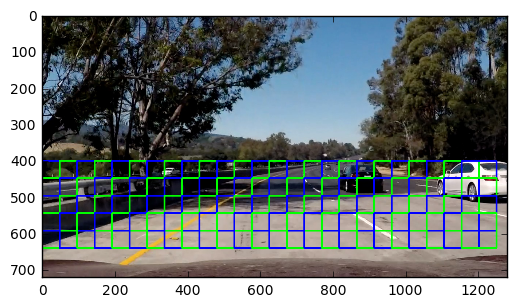

In [48]:
y_start_stop = [400, 656]
overlap = 0.5

img = mpimg.imread("test_images/test5.jpg")
draw_img = np.copy(img)
img = img.astype(np.float32)/255
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96),
                         xy_overlap=(overlap, overlap))
window_img = draw_boxes(draw_img, windows, color=(0,0,255), thick=4, color2=(0,255,0))
plt.imshow(window_img)

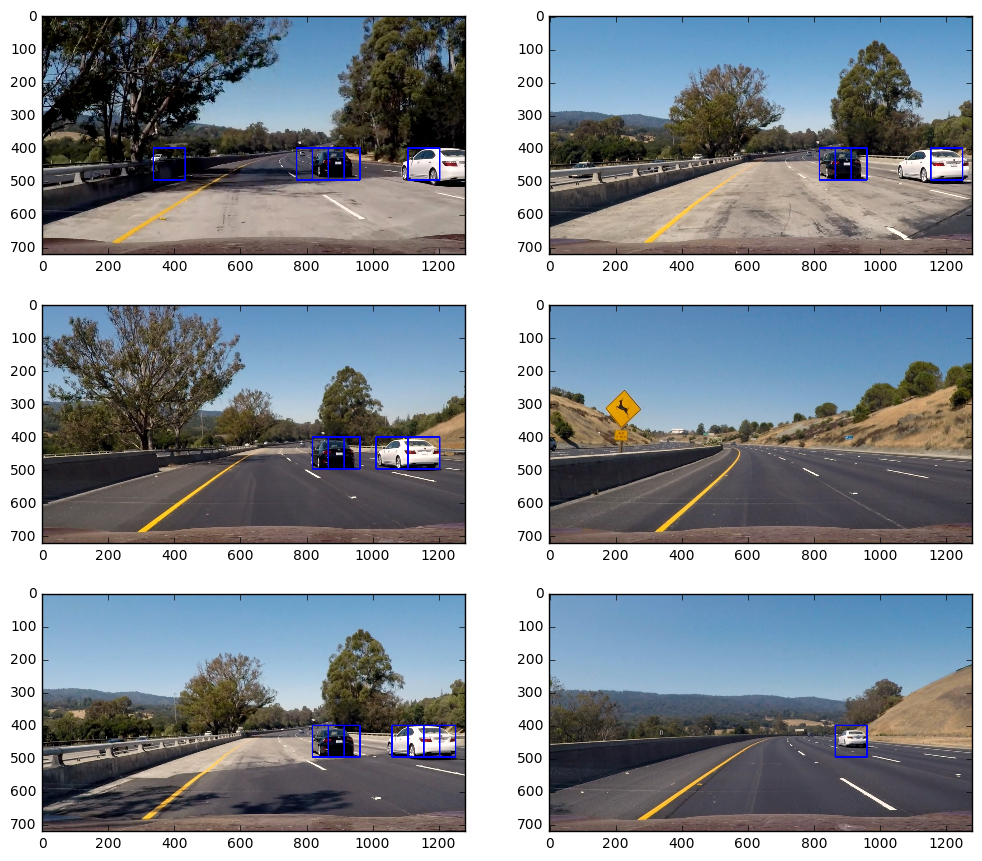

In [49]:
searchpath = "test_images/*"
test_images = glob.glob(searchpath)
images= []
titles = []
y_start_stop = [400, 656]
overlap = 0.5

for img_src in test_images:
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255    
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96),
                         xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_Scaler,   color_space=color_space,                             
                                                        spatial_size=spatial_size, 
                                                        hist_bins=hist_bins, 
                                                        orient=orient, 
                                                        pix_per_cell=pix_per_cell, 
                                                        cell_per_block=cell_per_block, 
                                                        hog_channel=hog_channel, 
                                                        spatial_feat=spatial_feat, 
                                                        hist_feat=hist_feat,
                                                        hog_feat=hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=4)
    images.append(window_img)
    titles.append('')
    
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)
    

In [16]:
def convert_color(img, conv="RGB2YCrCb"):
    if conv == "RGB2YCrCb":
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)    
    if conv == "BGR2YCrCb":
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)    
    if conv == "RGB2LUV":
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [17]:
out_images = []
out_maps = []
out_boxes = []
out_titles = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in test_images:
    img_boxes = []
    count = 0
    img=mpimg.imread(img_src)
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255    
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, "RGB2YCrCb")
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),  (np.int(imshape[0]/scale))))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            xpos = xb * cells_per_step
            ypos = yb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_Scaler.transform(np.hstack((spatial_features, hist_features, hog_features))).reshape(1, -1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),4) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1

    out_images.append(draw_img)
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    


/home/carnd/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/carnd/anaconda3/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d

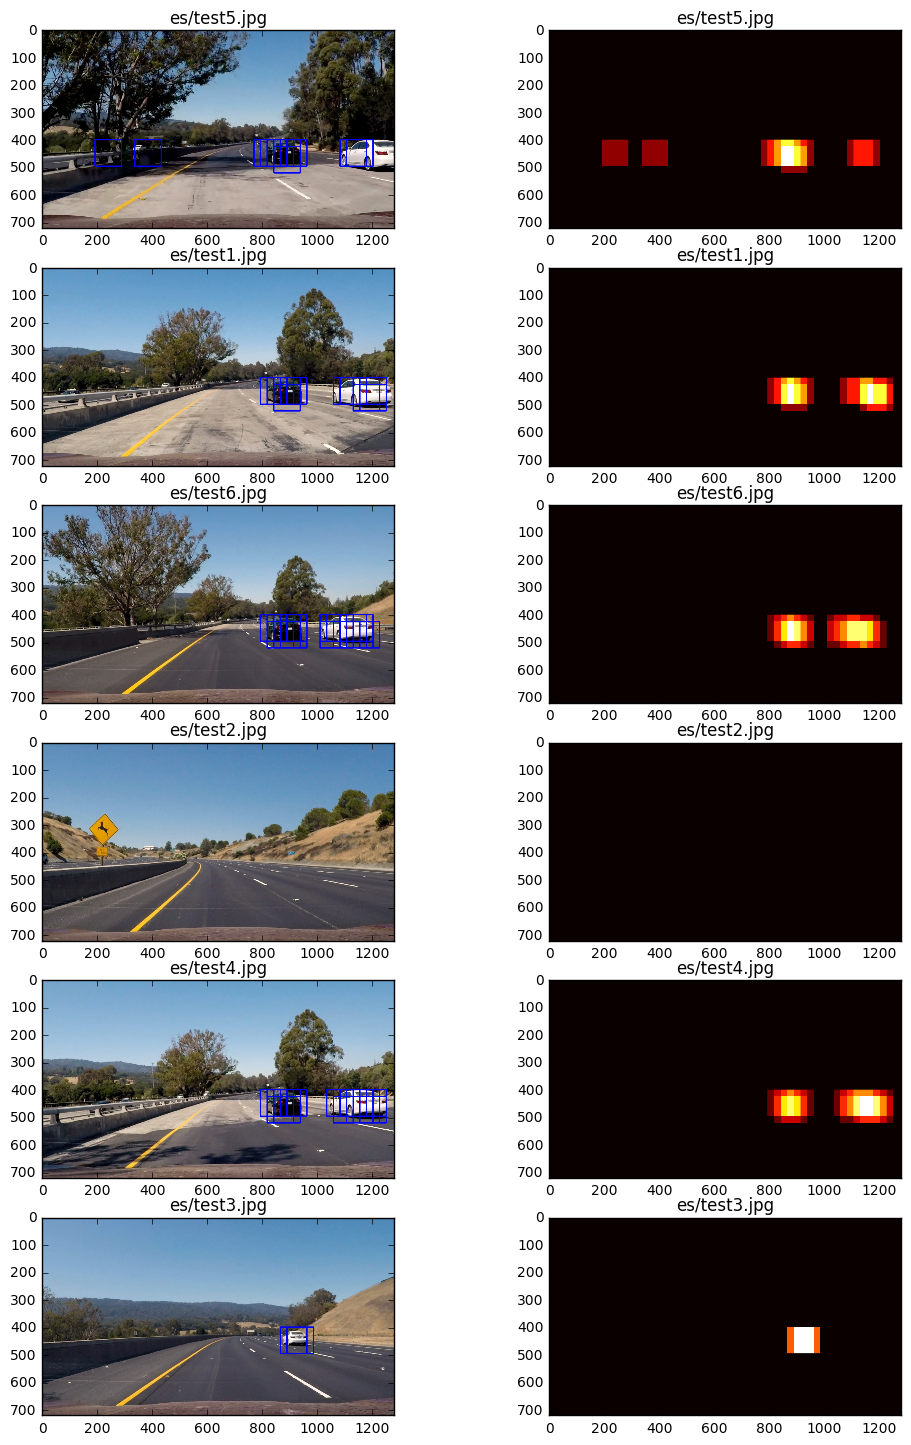

In [18]:
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [19]:
def find_cars(img, scale):
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255    
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, "RGB2YCrCb")
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),  (np.int(imshape[0]/scale))))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            xpos = xb * cells_per_step
            ypos = yb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_Scaler.transform(np.hstack((spatial_features, hist_features, hog_features))).reshape(1, -1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),4) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap
    

In [31]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] +1):
        nonzero = (labels[0] == car_number).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
        
    return img
        

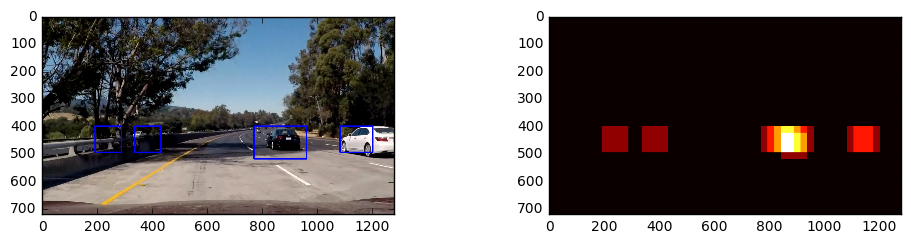

In [43]:
out_images = []
out_maps = []
out_boxes = []
out_titles = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in test_images[:1]:
    img=mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)    
    out_images.append(heat_map)
    out_titles.append('')
    out_titles.append('')

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)    

In [ ]:
out_images = []
out_maps = []
out_boxes = []
out_titles = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in test_images[:1]:
    img=mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)    
    out_images.append(heat_map)
    out_titles.append('')
    out_titles.append('')

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)    

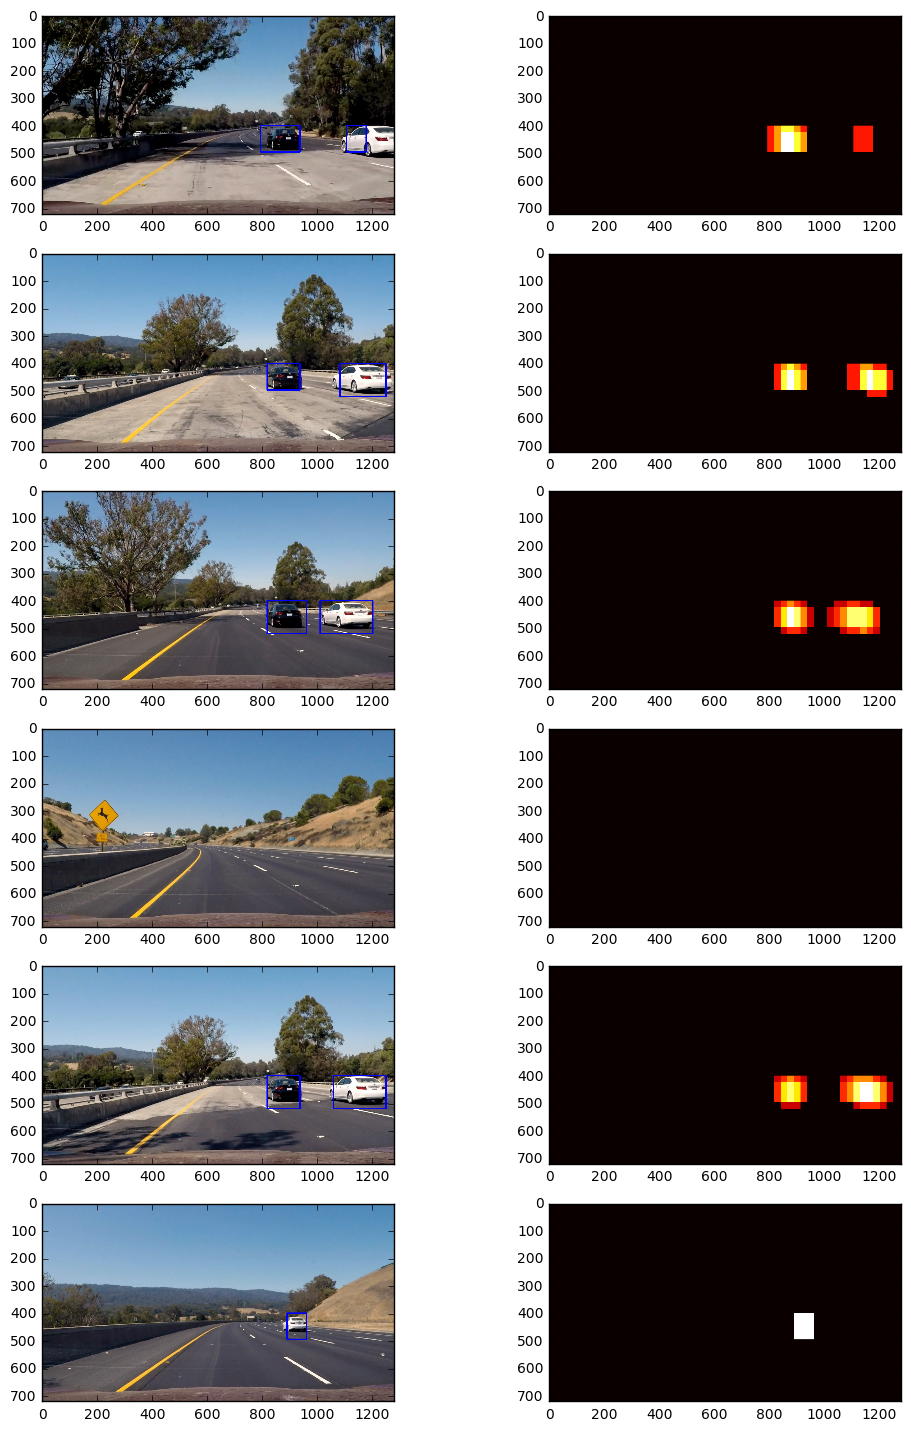

In [42]:
out_images = []
out_maps = []
out_boxes = []
out_titles = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in test_images:
    img=mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    heat_map = apply_threshold(heat_map, 1.)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)    
    out_images.append(heat_map)
    out_titles.append('')
    out_titles.append('')

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)    

In [36]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale)
    heat_map = apply_threshold(heat_map, 1.)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output="project_output.mp4"
clip=VideoFileClip("project_video.mp4")
test_clip=clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

In [37]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output="project_output.mp4"
clip=VideoFileClip("project_video.mp4")
test_clip=clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [13:45<00:00,  1.64it/s]    | 1/1261 [00:00<16:30,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 



In [38]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))